# Обучение модели классификации текстов

## Проект "Проверка токсичных комментариев в интернет-магазине "Викишоп" #

## Описание проекта ##

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Цель проекта - обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.

***План работы:***

- загрузить и подготовить данные,
- обучите разные модели,
- сделать выводы.

***Описание данных***

Данные находятся в файле /datasets/toxic_comments.csv. 

Столбец text в нём содержит текст комментария, а toxic — целевой признак.

In [1]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import seaborn as sns

!pip install pymystem3



from pymystem3 import Mystem
import nltk
nltk.download('omw-1.4') #присипользовании  WordNetLemmatizer запросили сделать эту загрузку
nltk.download('averaged_perceptron_tagger') #попрсили загурзить, когда проставляла POS-теги при лемматизации
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet
stopwords = set(nltk_stopwords.words('russian'))
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_score, fbeta_score, make_scorer, precision_recall_curve
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

#для pipelime
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

  Using cached pymystem3-0.2.0-py3-none-any.whl (10 kB)


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LeeLoo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LeeLoo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LeeLoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LeeLoo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#загрузка обучающей выборки

data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv') 

In [3]:
#посмотрим на данные в таблице
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
#информация по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
#удалим столбец unnamed

data = data.drop(['Unnamed: 0'], axis=1)

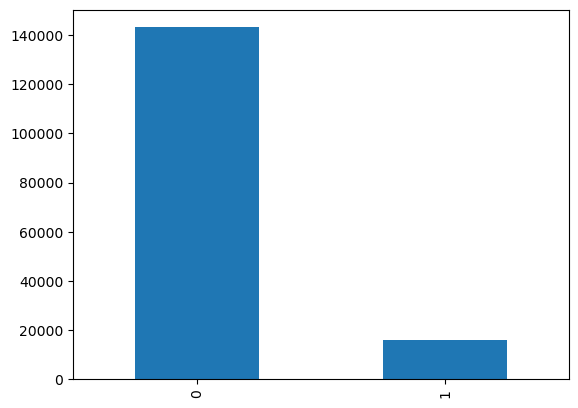

In [6]:
#проверка распределения классов в обучающей выборке
data['toxic'].value_counts().plot.bar();

In [7]:
print(data['toxic'].value_counts())

0    143106
1     16186
Name: toxic, dtype: int64


In [8]:
#расчет для параметра scale_pos_weight для модели CatBoostClassifier, округлим до целого
scale_pos_weight = 143106/16186
print(round(scale_pos_weight))

9


***Вывод:*** В данных нет пропусков. Данные не сбалансированы, учтем это в параметре class_weight  модели при прогнозировани.

## 1. Подготовка данных ##

In [9]:
%%time
#очистим данные от лишних симфолом, разделителей, пробелы в начале и конце строки и пр.
def cleaning(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    text = text.lower()
    return text

data['text'] = data['text'].apply(cleaning)

Wall time: 1.48 s


In [10]:
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impro...,0
4,you sir are my hero any chance you remember wh...,0


***Токенизация и лемматизация через функцию***

In [11]:
%%time
#проведем лемматизацию с помощью лексической базы Wordnet для английского языка
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    #сопоставление POS-тегов NLTK с форматом, принятым лемматизатором wordnet
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemm_text_with_pos_tag (text):
   
    new_text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    text = " ".join(new_text)
    return text

data['new_text'] = data['text'].apply(lemm_text_with_pos_tag)

Wall time: 1h 6min 49s


In [12]:
data.head()

,text,toxic,new_text
0,explanation why the edits made under my userna...,0,explanation why the edits make under my userna...
1,daww he matches this background colour im seem...,0,daww he match this background colour im seemin...
2,hey man im really not trying to edit war its j...,0,hey man im really not try to edit war it just ...
3,more i cant make any real suggestions on impro...,0,more i cant make any real suggestion on improv...
4,you sir are my hero any chance you remember wh...,0,you sir be my hero any chance you remember wha...


***Вариант токенизации и лемматизации, когда делаю без функции***

In [13]:
corpus = data['text'].values
corpus = corpus[0]
corpus

'explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired now'

In [14]:
# Tokenize: Split the sentence into words
#corpus = str(corpus)
word_list = corpus.split()
print(word_list)

['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', 'they', 'werent', 'vandalisms', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fac', 'and', 'please', 'dont', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'im', 'retired', 'now']


In [15]:
lemmatizer = WordNetLemmatizer()
lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
print(lemmatized_output)

explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalism just closure on some gas after i voted at new york doll fac and please dont remove the template from the talk page since im retired now


In [16]:
# Lemmatize with POS Tag
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()


# 3. Lemmatize a Sentence with the appropriate POS tag
sentence = "The striped bats are hanging on their feet for best"
new_text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(lemmatized_output)]

print(new_text)
    


['explanation', 'why', 'the', 'edits', 'make', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'be', 'revert', 'they', 'werent', 'vandalism', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'vote', 'at', 'new', 'york', 'doll', 'fac', 'and', 'please', 'dont', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'im', 'retire', 'now']


In [17]:
text = text = " ".join(new_text)
text

'explanation why the edits make under my username hardcore metallica fan be revert they werent vandalism just closure on some gas after i vote at new york doll fac and please dont remove the template from the talk page since im retire now'

In [18]:
data1 = pd.DataFrame([text])
data1

,0
0,explanation why the edits make under my userna...


In [19]:
data.head()

,text,toxic,new_text
0,explanation why the edits made under my userna...,0,explanation why the edits make under my userna...
1,daww he matches this background colour im seem...,0,daww he match this background colour im seemin...
2,hey man im really not trying to edit war its j...,0,hey man im really not try to edit war it just ...
3,more i cant make any real suggestions on impro...,0,more i cant make any real suggestion on improv...
4,you sir are my hero any chance you remember wh...,0,you sir be my hero any chance you remember wha...


***Разобъем данные на выборки***

In [20]:
#введем коснтанту RANDOM_STATE
RANDOM_STATE = 12345

target = data['toxic']
features = data.drop(['toxic'], axis=1)
features = features.drop(['text'], axis=1)


#Разобьем выборку по отношению 50 - 20, на обучающую и тестовую. Валидационная нам не потребуется, 
#так как при подборе параментров модели с помощью greadsearch будем использовать кросс-валидацию

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.2, 
                                                                              random_state=RANDOM_STATE)


In [21]:
print('Размер тренировочной выборки', features_train.shape)
print('Размер тестовой выборки', features_test.shape)
print(features_train.columns)

Размер тренировочной выборки (127433, 1)
Размер тестовой выборки (31859, 1)
Index(['new_text'], dtype='object')


***Удалим стоп-слова, а вектрризвацию проведем через Pipeline в GreadSearch***

In [ ]:
#установим список стоп-слов

stopwords = set(nltk_stopwords.words('english')) 
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

#создадим матрицу cо значениями 

tfidf_train = count_tf_idf.fit_transform(features_train['new_text'])
tfidf_test = count_tf_idf.transform(features_test['new_text'])

print(features_train.shape)
print(features_test.shape)

In [22]:
#установим список стоп-слов

stopwords = set(nltk_stopwords.words('english')) 

#создаем объект count_tf_idf для использования TfidfVectorizer (его будем использовать ниже в pipeline при обучении моделей)
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

#создадим матрицу cо значениями 

tfidf_train = count_tf_idf.fit_transform(features_train['new_text'])
tfidf_test = count_tf_idf.transform(features_test['new_text'])

print(features_train.shape)
print(features_test.shape)

(127433, 1)
(31859, 1)


In [23]:
print(tfidf_train.shape)
print(tfidf_test.shape)

(127433, 176440)
(31859, 176440)


## 2. Обучение 

### Выбор лучшей модели прогнозирования из трех: LogisticRegression, DecisionTreeClassifier, CatBoostClassifier ##

*Примечание: при подборе параметров моделей был использован более широкий диапазон, но когда были найдены оптимальные параметры, диапазон был сужен, чтобы при обновлении проекта обучение не длилось бесссмысленно долго.

***Обучение модели LogisticRegression***

In [54]:
model_lr = LogisticRegression(random_state = RANDOM_STATE)

In [55]:
%%time
pipe = make_pipeline(TfidfVectorizer(), 
                     LogisticRegression()) 

parametrs = {
    'logisticregression__solver':['liblinear', 'newton-cg'],
    'logisticregression__C': [0.1, 7, 10],
    'logisticregression__class_weight': ['balanced']
}
grid = GridSearchCV(pipe,
                     parametrs, cv=5,  scoring='f1', verbose=3)
grid.fit(features_train['new_text'], target_train)
#выводим результат
print(grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END logisticregression__C=0.1, logisticregression__class_weight=balanced, logisticregression__solver=liblinear;, score=0.672 total time=   5.2s
[CV 2/5] END logisticregression__C=0.1, logisticregression__class_weight=balanced, logisticregression__solver=liblinear;, score=0.677 total time=   5.0s
[CV 3/5] END logisticregression__C=0.1, logisticregression__class_weight=balanced, logisticregression__solver=liblinear;, score=0.675 total time=   4.9s
[CV 4/5] END logisticregression__C=0.1, logisticregression__class_weight=balanced, logisticregression__solver=liblinear;, score=0.683 total time=   5.0s
[CV 5/5] END logisticregression__C=0.1, logisticregression__class_weight=balanced, logisticregression__solver=liblinear;, score=0.684 total time=   4.9s
[CV 1/5] END logisticregression__C=0.1, logisticregression__class_weight=balanced, logisticregression__solver=newton-cg;, score=0.672 total time=   6.4s
[CV 2/5] END logisticr

In [57]:
#передадим лучшие параметры на вход модели

model_lr = grid.best_estimator_

In [44]:
#сохраним и выведем на печать лучшую метрику для модели

best_score_lr = grid.best_score_
print(best_score_lr)

0.7160109767612151


***Обучение модели DecisionTreeClassifier***

In [28]:
%%time
pipe = make_pipeline(TfidfVectorizer(), 
                     DecisionTreeClassifier(criterion='gini',random_state=RANDOM_STATE)) 

parametrs = {
    'decisiontreeclassifier__max_depth':range (160,360, 50),
    'decisiontreeclassifier__class_weight': ['balanced']
}
grid = GridSearchCV(pipe,
                     parametrs, cv=5,  scoring='f1', verbose=3)
grid.fit(features_train['new_text'], target_train)
#выводим результат
print(grid.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=160;, score=0.565 total time= 1.1min
[CV 2/5] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=160;, score=0.579 total time= 1.1min
[CV 3/5] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=160;, score=0.588 total time= 1.2min
[CV 4/5] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=160;, score=0.576 total time= 1.0min
[CV 5/5] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=160;, score=0.575 total time= 1.1min
[CV 1/5] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=210;, score=0.567 total time= 1.1min
[CV 2/5] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=210;, score=0.576 total time= 1.0min
[CV 3/5] END decisiontr

In [29]:
#передадим лучшие параметры на вход модели

model_dt = grid.best_estimator_

In [30]:
#сохраним и выведем на печать лучшую метрику для модели

best_score_dt = grid.best_score_
print(best_score_dt)

0.5780526136111316


***Обучение модели CatBoostClassifier***

In [31]:
%%time
pipe = make_pipeline(TfidfVectorizer(), 
                     CatBoostClassifier(verbose=False, iterations=250, scale_pos_weight = 9, random_state = RANDOM_STATE)) 

parametrs = {
    'catboostclassifier__depth':[4, 6],
    'catboostclassifier__learning_rate': [0.1, 0.15]
}
grid = GridSearchCV(pipe,
                     parametrs, cv=5,  scoring='f1', verbose=3)
grid.fit(features_train['new_text'], target_train)
#выводим результат
print(grid.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END catboostclassifier__depth=4, catboostclassifier__learning_rate=0.1;, score=0.681 total time= 1.6min
[CV 2/5] END catboostclassifier__depth=4, catboostclassifier__learning_rate=0.1;, score=0.681 total time= 1.6min
[CV 3/5] END catboostclassifier__depth=4, catboostclassifier__learning_rate=0.1;, score=0.684 total time= 1.6min
[CV 4/5] END catboostclassifier__depth=4, catboostclassifier__learning_rate=0.1;, score=0.686 total time= 1.6min
[CV 5/5] END catboostclassifier__depth=4, catboostclassifier__learning_rate=0.1;, score=0.687 total time= 1.6min
[CV 1/5] END catboostclassifier__depth=4, catboostclassifier__learning_rate=0.15;, score=0.703 total time= 1.6min
[CV 2/5] END catboostclassifier__depth=4, catboostclassifier__learning_rate=0.15;, score=0.700 total time= 1.6min
[CV 3/5] END catboostclassifier__depth=4, catboostclassifier__learning_rate=0.15;, score=0.701 total time= 1.6min
[CV 4/5] END catboostclassifier__

In [32]:
#передадим лучшие параметры на вход модели

model_cb = grid.best_estimator_

In [33]:
#сохраним и выведем на печать лучшую метрику для модели

best_score_cb = grid.best_score_
print(best_score_cb)

0.7160109767612151


***Выбор лучшей модели***

In [34]:
#построим датасет для сравнения метрики F1 по моделям

index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier']
data = {'F1-score':[best_score_lr,
                    best_score_dt,
                    best_score_cb]}

best_score_by_model = pd.DataFrame(data=data, index=index)

#добавим новый столбец, который покажет соответствует ли метрика условию задачи

best_score_by_model['метрика качества F1>0.75'] = best_score_by_model['F1-score'] > 0.75
best_score_by_model

,F1-score,метрика качества F1>0.75
LogisticRegression,0.771294,True
DecisionTreeClassifier,0.578053,False
CatBoostClassifier,0.716011,False


***Вывод:***

С помощью подбора параметром и метода кросс-валидации мы проверили на обучающей выборке 3 модели LogisticRegression, DecisionTreeClassifier, CatBoostClassifier.

По условиям проекта необходимо подобрать модель с метрикой F1 не ниже 0,75. Под этом критерий попадает только модель Логистической регресии, ее F1 равна 0,769057. Что еще важно это одна из самых быстрых моделей в обучении. 

*Примечение: У Модели CatBoostClassifier есть потенциал достичь требуемую метрику, но на обучение уходит очень  много времени. 

## Проверка лучшей модели на тестовой выборке ##

In [61]:
#обучим модель по полученным параметрам и рассчитаем ее показатели на тестовой выборке
model_lr = grid.best_estimator_
predictions_test = grid.best_estimator_.predict(features_test['new_text'])
#predictions_test= model_lr.predict(features_test)

In [62]:
print(predictions_test)

[0 1 0 ... 0 0 0]


In [63]:
#рассчитаем метрику F1 на тестовой выборке

f1_score_lr = f1_score(target_test, predictions_test)

print('f1-мера - среднее гармоническое полноты и точности:', f1_score_lr) 

f1-мера - среднее гармоническое полноты и точности: 0.779373743177248


***Вывод:*** На тестовой выборке метрика даже немного выше, чем на кросс-валидации, что хорошо. 

***Матрица ошибок и график полноты и точности для лучшей модели***

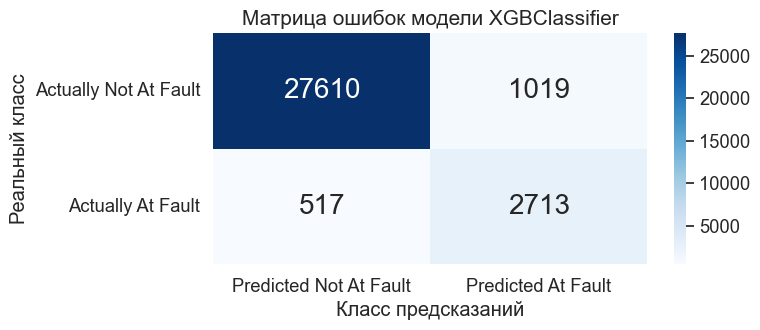

In [65]:
#построим матрицу ошибок

cm_lr = confusion_matrix(target_test, predictions_test)
cm = pd.DataFrame(cm_lr, index=['Actually Not At Fault', 'Actually At Fault'],
                 columns=['Predicted Not At Fault', 'Predicted At Fault'])


sns.set(font_scale=1.2)
plt.figure(figsize=(7,3))
    
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues",xticklabels=cm.columns, yticklabels=cm.index, annot_kws={"size": 20})
plt.title("Матрица ошибок модели XGBClassifier", size=15)
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс');


In [66]:
TP3 = cm_lr[0][0]
TN3 = cm_lr[1][1]
FP3 = cm_lr[0][1]
FN3 = cm_lr[1][0]
total = cm_lr[0][0]+cm_lr[1][1]+cm_lr[0][1]+cm_lr[1][0]

print('Всего предсказаний:',total)
print(f'Правильно классифицированы : {np.round((TP3+TN3)/total*100)}%')
print(f'Правильно классифицированны негативные комментарии: {np.round(TP3/(TP3+FN3)*100)}%')
print(f'Правильно классифицированнр отсутствие негативных комментариев: {np.round(TN3/(TN3+FP3)*100)}%')
print(f'Прогнозируемое начичие негативных комментарией, которые есть на самом деле: {np.round(TP3/(TP3+FP3)*100)}%')
print(f'Прогнозируемое негативных комментарией, которой так же на самом деле нет: {np.round(TN3/(TN3+FN3)*100)}%')

Всего предсказаний: 31859
Правильно классифицированы : 95.0%
Правильно классифицированны негативные комментарии: 98.0%
Правильно классифицированнр отсутствие негативных комментариев: 73.0%
Прогнозируемое начичие негативных комментарией, которые есть на самом деле: 96.0%
Прогнозируемое негативных комментарией, которой так же на самом деле нет: 84.0%


Хорошие показатели, высокий процент негативных комментариев определен верно и низкий процент ошибок.

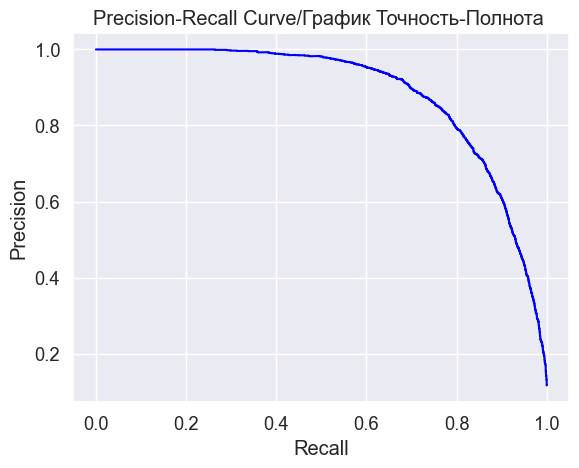

In [69]:
#график точноти и полноты модели Линейной регрессии

probabilities_test = model_lr.predict_proba(features_test['new_text'])
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_test[:, 1])

#график
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#название осей
ax.set_title('Precision-Recall Curve/График Точность-Полнота ')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#отобразиь график
plt.show() 

Чем выше график, тем лучше работает модель. Наша модель работает хорошо.

## 3. ВЫВОДЫ

Цель проекта - обучить модель классифицировать комментарии на позитивные и негативные.

Что было сделано:
1. Мы проверили данные на сбалансированность  классов, оказалось, что они не сбалансированы, этот момент мы учли в 
параметрах модели, укаазыв class_weight 'balanced'.

2. Очистили данные от лишних символов, привели их к стандартной кодировке кодировку Unicode U, проведем лемматизацию с помощью лексической базы Wordnet для английского языка.

3. Разбили данные на выборки, удалили стоп-слова и провели векторизацию.

4. Обучили с помощью подбора параметров и кросс-валидации 3 модели - LogisticRegression, DecisionTreeClassifier, CatBoostClassifier. Но по условию задачи требуемой метрике F1 >0.75 подошла только модель LogisticRegression, ее F1 составила 0.769057.

Можно было бы еще потренирваться подобрать параметры для модели CatBoostClassifier, ее метрика относительно близка к требуемоей, но на её обучение уходит слишком много времени.  А модель Логистической регрессии сработала быстро и точно, поэтому остановились на ней.

5. Проверил метрику выбранной модели на тестовой выборке, ее F1 составила 0.779374, что хорошо значит модель не переобучилась и наша тестовая выборка была репрезентативной.

6. Построили матрицу ошибок и график полноты-точности, тут тоже модель показала хороший результат - большой процент точности предсказаний и мало ошибок. 

Поэтому полученную  модель Логистической регрессии рекомендуем использовать для определения токсичных комментариев в интернет-магазине «Викишоп».

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны